In [1]:
import math
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import qmc

from glob import glob
import os

from numba import jit
import dask

import regionmask
import matplotlib.pyplot as plt

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="5GiB",
    walltime="03:00:00",
)

cluster.scale(jobs=20)

In [3]:
# print(cluster.job_script())

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.155:42179,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preliminaries

In [5]:
#################
## Directories ##
#################
nldas_path = '/storage/group/pches/default/public/NLDAS/'
smap_path = '/storage/group/pches/default/public/SMAP/'
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

In [6]:
from numba import njit, prange

################
## Model code ##
################

@njit(parallel=False)
def simulate_water_balance_loop(
    Ws_frac_init,
    Wi_init,
    Sp_init,
    P,
    T,
    Ts,
    Tm,
    rootDepth_oGS,
    rootDepth_GS_factor,
    awCap,
    wilting_point,
    GS_start,
    GS_length,
    lai,
    Kc,
    alpha,
    betaHBV,
    phi,
    doy,
):
    """
    Inputs:
     - Ws_frac_init: initial soil moisture content []
     - Wi_init: initial canopy water storage [mm]
     - Sp_init: initial snowpack [mm]
     - Wg_init: initial groundwater [mm]
     - P: daily precipitation timeseries [mm]
     - T: daily mean temperature timeseries [C]
     - Ts: snowfall threshold [C]
     - Tm: snowmelt threshold [C]
     - rootDepth_oGS: root depth outside the growing season [mm]
     - rootDepth_GS: root depth during the growing season [mm]
     - awCap: available water capacity [mm/m]
     - wilting_point: wilting point as fraction of Wcap []
     - GS_start: planting day / start of growing season []
     - GS_length: length of growing season []
     - Kc: crop scalar factor timeseries []
     - lai: leaf area index timeseries []
     - alpha: drying function scale parameter []
     - betaHBV: HBV direct recharge parameter []
     - phi: Latitude [deg]
     - doy: day of year []

    Outputs:
     - Ws: daily soil moisture content timeseries [mm]
     - Ws_frac: daily soil moisture fraction timeseries []
    """
    def calculate_potential_evapotranspiration(T, N, phi):
        """
        Inputs:
         - T: daily mean temperature [C]
         - N: day of year
         - phi: latitude [deg]
        Outputs:
         - daily potential evapotranspiration calculated via the Hamon method [mm]
        Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
        """
        
        # Calculate solar declination (delta)
        delta = -23.44 * math.cos(math.radians((360 / 365) * (N + 10)))
        
        # Calculate fractional day length (Lambda)
        Lambda = (1 / math.pi) * math.acos(
            -math.tan(math.radians(phi)) * math.tan(math.radians(delta))
        )
        
        # Calculate saturation vapor pressure
        if T > 0:
            Psat = 0.61078 * np.exp((17.26939 * T) / (T + 237.3))
        else:
            Psat = 0.61078 * np.exp((21.87456 * T) / (T + 265.5))
        
        # Calculate saturation vapor density (rho_sat)    
        rho_sat = (2.167 * Psat) / (T + 273.15)
        
        # Calculate potential evapotranspiration (PET)
        PET = 330.2 * Lambda * rho_sat
        
        return PET

    ##################################
    # Initialization
    ##################################
    # Simulation dimensions
    nx, ny, nt = T.shape
    
    # Soil moisture capacity
    Wcap = np.empty((nx,ny,366))

    # Soil moisture capacity
    for ix in range(nx):
        for iy in range(ny):
            for t in range(366):
                if (t < GS_start[ix,iy]) or (t > (GS_start[ix,iy] + GS_length[ix,iy])):
                    # outside GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * rootDepth_oGS[ix,iy] / 1000
                else:
                    # during GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * (rootDepth_GS_factor[ix,iy] * rootDepth_oGS[ix,iy]) / 1000

    # Soil moisture [mm]
    Ws = np.empty_like(T)
    Ws[:,:,0] = Ws_frac_init * Wcap[:,:,0]

    # Soil moisture out [mm]
    Ws_out = np.empty_like(T)
    Ws_out[:,:,0] = Ws[:,:,0]

    # Soil moisture fraction
    Ws_frac = np.empty_like(T)
    Ws_frac[:,:,0] = Ws_frac_init
    
    # Canopy water storage
    Wi = np.empty((nx,ny,2))
    Wi[:,:,0] = Wi_init
    
    # Snowpack
    Sp = np.empty((nx,ny,2))
    Sp[:,:,0] = Sp_init

    ######################################
    # Begin simulation
    ######################################
    for ix in range(nx):
        for iy in range(ny):
            for t in range(1, nt):
                # t runs from 1 to n_sim
                # t2 and t2o are 0 or 1 oppositely (used for untracked variables)
                t2 = t % 2
                t2o = int(not(t2))
        
                ################
                # Snowfall
                ################
                # Precipitation is assumed to be entirely snow/rain
                # if temperature is below/above threshold (Ts)
                if T[ix,iy,t] < Ts:
                    Ps = P[ix,iy,t]
                    Pa = 0
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o] + Ps
                else:
                    Pa = P[ix,iy,t]
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o]
        
                ################
                # Snowmelt
                ################
                # Snowmelt is assumed to occur if temperature
                # is above a threshold (Tm), but is limited to
                # the volume of the snowpack
                if T[ix,iy,t] > Tm:
                    Ms = 2.63 + 2.55 * T[ix,iy,t] + 0.0912 * T[ix,iy,t] * Pa
                    if Ms > Sp[ix,iy,t2]:
                        Ms = Sp[ix,iy,t2]
                        Sp[ix,iy,t2] = 0
                    else:
                        Sp[ix,iy,t2] = Sp[ix,iy,t2] - Ms
                else:
                    Ms = 0.0

                #########################
                # Canopy & throughfall
                #########################
                # Maximum canopy storage scales with LAI
                Wi_max = 0.25 * lai[ix,iy,doy[t]]

                # Open water evaporation rate assumed to be PET
                Eow = calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                # Canopy evaporation
                Ec = Eow * ((Wi[ix,iy,t2o] / Wi_max) ** 0.6666667)

                # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
                # Throughfall if zero if all rainfall goes to canopy
                if Wi_max < Pa + Wi[ix,iy,t2o] - Ec:
                    Pt = Pa - Ec - (Wi_max - Wi[ix,iy,t2o])
                else:
                    Pt = 0

                # Update canopy storage
                if Wi[ix,iy,t2o] + (Pa - Pt) - Ec <= Wi_max:
                    if Wi[ix,iy,t2o] + (Pa - Pt) - Ec > 0.0:
                        Wi[ix,iy,t2] = Wi[ix,iy,t2o] + (Pa - Pt) - Ec
                    else:
                        Wi[ix,iy,t2] = 0.0
                else:
                    Wi[ix,iy,t2] = Wi_max

                ########################
                # Evapotranspiration
                ########################
                # Potential ET scales with (annual) crop-specific coefficient
                PET = Kc[ix,iy,doy[t]] * calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                
                # Calculate actual evapotranspiration
                # Actual ET is limited by water availability (throughfall + snowmelt)
                # otherwise the difference is scaled by drying function
                if (Pt + Ms) >= PET:
                    AET = PET
                else:
                    g = (1 - np.exp(-alpha[ix,iy] * Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]])) / (1 - np.exp(-alpha[ix,iy]))
                    AET =  g * (PET - Pt - Ms)

                ################
                # Runoff
                ################
                # HBV direct groundwater recharge (can also be thought of as runoff)
                # scales nonlinearly with saturation in the active zone
                # Direct groundwater recharge (HBV)
                Id = (Pt + Ms) * (Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]]) ** betaHBV[ix,iy]
                
                ################
                # Soil moisture
                ################
                # Soil surplus is the leftover water after saturating soils
                # It gets partitioned to more runoff and groundwater recharge
                if Wcap[ix,iy,doy[t]] < Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET:
                    S = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - Wcap[ix,iy,doy[t]]
                else:
                    S = 0

                # Update soil moisture
                Ws[ix,iy,t] = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - S

                # Soil moisture must be positive
                if Ws[ix,iy,t] < 0:
                    Ws[ix,iy,t] = 0.0

                # Wilting point in mm
                wilting_point_mm = wilting_point[ix,iy] * Wcap[ix,iy,doy[t]]
                
                # Soil wetness
                # Ws_frac[ix,iy,t] = (Ws[ix,iy,t] + wilting_point_mm) / (Wcap[ix,iy,doy[t]] + wilting_point_mm)

                # Soil moisture out (+ wilting point)
                Ws_out[ix,iy,t] = Ws[ix,iy,t] + wilting_point_mm
    
    # Return
    return Ws_out #, Ws, Wcap, Ms_out, Sp, Pa_out, Ps_out #Wg, AET_out, PET_out, g_out, Sp, Pt_out, Wcap

## Precalibration (central US test case)

### Setup

In [7]:
# Subset to central US
def _subset_centralUS(ds):
    # Define central US
    centralUS_states = ["Illinois", "Iowa", "Wisconsin", "Minnesota", "North Dakota", "South Dakota", "Nebraska", "Kansas", "Missouri", "Indiana", "Ohio", "Michigan", "Kentucky"]
    # Subset
    centralUS_index = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.map_keys(centralUS_states)
    centralUS_mask = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.mask(ds)
    ds_centralUS = ds.where(centralUS_mask.isin(centralUS_index), drop=True)
    # Return
    return ds_centralUS

In [8]:
#############################################
### CLimate forcing & geoophysical inputs ###
#############################################
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz'):
    # Climate drivers from NLDAS
    year = '20'
    files = glob(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A{year}*.nc')
    ds_nldas_forcing = _subset_centralUS(xr.concat([xr.open_dataset(file) for file in files], dim='time'))

    # Geophysical inputs
    ds_lai = _subset_centralUS(xr.open_dataset(f'{project_path}/WBM/geo_inputs/LAI_clima_NLDASgrid.nc'))
    ds_awCap = _subset_centralUS(xr.open_dataset(f'{project_path}/WBM/geo_inputs/NLDAS_NOAH_awCap.nc'))
    ds_wiltingp = _subset_centralUS(xr.open_dataset(f'{project_path}/WBM/geo_inputs/NLDAS_NOAH_wiltingp.nc'))

    ds_soilfrac = _subset_centralUS(xr.open_dataset(f'{project_path}/WBM/geo_inputs/soilfrac_NLDASgrid.nc'))

    # Numpy arrays in correct order
    lats = ds_lai.lat.to_numpy()
    doy = ds_nldas_forcing.time.dt.dayofyear.to_numpy() - 1

    tas = np.transpose(ds_nldas_forcing['TMP'].to_numpy() - 273.15, (2,1,0))
    prcp = np.transpose(ds_nldas_forcing['APCP'].to_numpy(), (2,1,0))

    lai = np.transpose(ds_lai['LAI'].to_numpy(), (2,1,0))
    awCap = np.transpose(ds_awCap['awCap'].to_numpy())
    wiltingp = np.transpose(ds_wiltingp['wiltingp'].to_numpy())

    clayfrac = np.transpose(ds_soilfrac['GLDAS_soilfraction_clay'].to_numpy())
    sandfrac = np.transpose(ds_soilfrac['GLDAS_soilfraction_sand'].to_numpy())
    siltfrac = np.transpose(ds_soilfrac['GLDAS_soilfraction_silt'].to_numpy())

    # Store numpy for easy access
    np.savez(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz',
         tas=tas, prcp=prcp, lai=lai, awCap=awCap, wiltingp=wiltingp, lats=lats, doy=doy, clayfrac=clayfrac, sandfrac=sandfrac, siltfrac=siltfrac)

In [9]:
############################
### Uncertain parameters ###
############################
n_sample = 10_000

if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv'):
    # Define bounds
    awCap_factor_lower, awCap_factor_upper = 0.1, 5.
    wiltingp_factor_lower, wiltingp_factor_upper = 0.1, 5.

    # alpha range ~ 1-10
    alpha_lower, alpha_upper = 0.1 ,10
    # alpha_claycoef_lower, alpha_claycoef_upper = 0.0, 10.
    # alpha_sandcoef_lower, alpha_sandcoef_upper = 0.0, 10.
    # alpha_siltcoef_lower, alpha_siltcoef_upper = 0.0, 10.

    # betaHBV range ~ 1 - 10
    betaHBV_claycoef_lower, betaHBV_claycoef_upper = 0.0, 10.
    betaHBV_sandcoef_lower, betaHBV_sandcoef_upper = 0.0, 10.
    betaHBV_siltcoef_lower, betaHBV_siltcoef_upper = 0.0, 10.

    # GS_start_lower, GS_start_upper = 50, 200
    # GS_length_lower, GS_length_upper = 100, 200
    # rootDepth_oGS_lower, rootDepth_oGS_upper = 100, 1200
    # rootDepth_GS_factor_lower, rootDepth_GS_factor_upper = 2., 10.
    # rootDepth_all_lower, rootDepth_all_upper = 100, 2500

    # LHC sampling
    sampler = qmc.LatinHypercube(d=6)
    sample = sampler.random(n=n_sample)

    # l_bounds = [awCap_factor_lower, wiltingp_factor_lower, alpha_claycoef_lower, alpha_sandcoef_lower, alpha_siltcoef_lower, betaHBV_claycoef_lower, betaHBV_sandcoef_lower, betaHBV_siltcoef_lower]
    # u_bounds = [awCap_factor_upper, wiltingp_factor_upper, alpha_claycoef_upper, alpha_sandcoef_upper, alpha_siltcoef_upper, betaHBV_claycoef_upper, betaHBV_sandcoef_upper, betaHBV_siltcoef_upper]
    
    l_bounds = [awCap_factor_lower, wiltingp_factor_lower, alpha_lower, betaHBV_claycoef_lower, betaHBV_sandcoef_lower, betaHBV_siltcoef_lower]
    u_bounds = [awCap_factor_upper, wiltingp_factor_upper, alpha_upper, betaHBV_claycoef_upper, betaHBV_sandcoef_upper, betaHBV_siltcoef_upper]
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

    # Store as csv
    df = pd.DataFrame(data = sample_scaled,
                      columns = ['awCap_factor', 'wiltingp_factor',
                                 'alpha',
                                 'betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'])
    df['iparam'] = df.index
    df.to_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv', index=False)

In [10]:
# SMAP
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs.npy'):
    # Read all
    files = glob(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')
    ds_smap = xr.concat([_subset_centralUS(xr.open_dataset(file)[['sm_rootzone_wetness']]) for file in files], dim='time')
    
    # Store (and change units to kg/m3)
    np.save(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs.npy',
            np.transpose(ds_smap['sm_rootzone_wetness'].to_numpy(), (2,1,0)))

In [11]:
########################################################
########## SMAP and NLDAS data for validation ##########
#
# We use volumetric soil moisture anomalies 
# constructed from a weekly climatology 
# (following e.g. Ford & Quiring 2019)
########################################################
# SMAP
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs_anoms_weekly.npy'):
    # Read all
    files = glob(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')
    ds_smap = xr.concat([_subset_centralUS(xr.open_dataset(file)[['sm_rootzone']]) for file in files], dim='time')

    # Use weekly anomalies to validate across different obs
    ds_smap = ds_smap.assign_coords(week=ds_smap.time.dt.strftime("%W"))
    ds_smap_anom = (ds_smap.groupby('week') - ds_smap.groupby("week").mean("time"))
    
    # Store (and change units to kg/m3)
    np.save(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs_anoms_weekly.npy',
            np.transpose(1000 * ds_smap_anom['sm_rootzone'].to_numpy(), (2,1,0)))

# NLDAS
nldas_dict = {'VIC':'SOILM0_100cm', 'NOAH':'SOILM', 'MOSAIC':'SOILM'}

for model, var_id in nldas_dict.items():
    if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/{model}_obs_anoms_weekly.npy'):
        # Read all
        files = glob(f'{nldas_path}/{model}/daily/*.nc')
        ds_nldas = xr.concat([_subset_centralUS(xr.open_dataset(file)[[var_id]]) for file in files], dim='time')
    
        # Select correct depth
        if model in ['MOSAIC', 'NOAH']:
            ds_nldas = ds_nldas.isel(depth=1)
        else:
            ds_nldas = ds_nldas.isel(depth=0)
    
        # Use weekly anomalies to validate across different obs
        ds_nldas = ds_nldas.assign_coords(week=ds_nldas.time.dt.strftime("%W"))
        ds_nldas_anom = (ds_nldas.groupby('week') - ds_nldas.groupby("week").mean("time"))
        
        # Store (and change units to kg/m3)
        np.save(f'{project_data_path}/WBM/precalibration/centralUS/{model}_obs_anoms_weekly.npy',
                np.transpose(ds_nldas_anom[var_id].to_numpy(), (2,1,0)))

### Run ensemble

In [12]:
def run_WBMpy(forcing,
              alpha,
              betaHBV_claycoef,
              betaHBV_sandcoef,
              betaHBV_siltcoef,
              Ts,
              Tm,
              Kc,
              awCap_factor,
              wiltingp_factor,
              Ws_frac_init,
              Wi_init,
              Sp_init,
              GS_start,
              GS_length,
              rootDepth_oGS,
              rootDepth_GS_factor,
              iparam,
              store_path,
              simulate_water_balance_loop):
    
    # Read and extract inputs
    npz = np.load(forcing)
    tas_in = npz['tas']
    prcp_in = npz['prcp']
    lai_in = npz['lai']
    awCap = npz['awCap']
    wiltingp = npz['wiltingp']
    lats_in = npz['lats']
    doy_in = npz['doy']
    clayfrac = npz['clayfrac']
    sandfrac = npz['sandfrac']
    siltfrac = npz['siltfrac']
    
    # Setup arrays
    nlon, nlat = awCap.shape
    
    grid = np.ones((nlon, nlat))

    # alpha_coef = 1. + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    # alpha_coef = 1. + alpha_claycoef
    alpha_in =  alpha * grid

    betaHBV_coef = 1. + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac)
    betaHBV_in = betaHBV_coef * grid
    
    Kc_in = Kc * np.ones(lai_in.shape)
    awCap_in = awCap_factor * awCap
    wiltingp_in = wiltingp_factor * wiltingp
    Ws_frac_init_in = Ws_frac_init * grid
    Wi_init_in = Wi_init * grid
    Sp_init_in = Sp_init * grid
    GS_start_in = GS_start * grid
    GS_length_in = GS_length * grid
    rootDepth_oGS_in = rootDepth_oGS * grid
    rootDepth_GS_factor_in = rootDepth_GS_factor * grid

    # Run it
    out = simulate_water_balance_loop(
        Ws_frac_init = Ws_frac_init_in,
        Wi_init = Wi_init_in,
        Sp_init = Sp_init_in,
        P = prcp_in,
        T = tas_in,
        Ts = Ts,
        Tm = Tm,
        rootDepth_oGS = rootDepth_oGS_in,
        rootDepth_GS_factor = rootDepth_GS_factor_in,
        awCap = awCap_in,
        wilting_point = wiltingp_in,
        GS_start = GS_start_in,
        GS_length = GS_length_in,
        lai = lai_in,
        Kc = Kc_in,
        alpha = alpha_in,
        betaHBV = betaHBV_in,
        phi = lats_in,
        doy = doy_in
    )

    # Store
    np.save(f'{store_path}/{str(iparam)}_Ws.npy', out)

In [13]:
# Run ensemble
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv')

# Constants
Ts = -1.             # Snowfall threshold
Tm = 1.              # Snowmelt threshold
Ws_frac_init = 0.5   # Initial soil moisture
Wi_init = 0.         # Initial canopy water storage
Sp_init = 0.         # Initial snowpack

# Neglect influence of growing season for now
GS_start = 120
GS_length = 182
rootDepth_oGS = 1000
rootDepth_GS_factor = 1
Kc = 1

# Dask delayed
delayed = []
for iparam in range(10_000):
    # Check if done
    if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}_Ws.npy'):
        # Get uncertain parameters
        awCap_factor = df_param[df_param.iparam == iparam]['awCap_factor'].values[0]
        wiltingp_factor = df_param[df_param.iparam == iparam]['wiltingp_factor'].values[0]
        
        # alpha_claycoef = df_param[df_param.iparam == iparam]['alpha_claycoef'].values[0]
        # alpha_sandcoef = df_param[df_param.iparam == iparam]['alpha_sandcoef'].values[0]
        # alpha_siltcoef = df_param[df_param.iparam == iparam]['alpha_siltcoef'].values[0]

        alpha = df_param[df_param.iparam == iparam]['alpha'].values[0]    
        
        betaHBV_claycoef = df_param[df_param.iparam == iparam]['betaHBV_claycoef'].values[0]
        betaHBV_sandcoef = df_param[df_param.iparam == iparam]['betaHBV_sandcoef'].values[0]
        betaHBV_siltcoef = df_param[df_param.iparam == iparam]['betaHBV_siltcoef'].values[0]

        # Delayed calculation
        tmp = dask.delayed(run_WBMpy)(
            forcing = f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz',
            # alpha_claycoef = alpha_claycoef,
            # alpha_sandcoef = alpha_sandcoef,
            # alpha_siltcoef = alpha_siltcoef,
            alpha = alpha,
            betaHBV_claycoef = betaHBV_claycoef,
            betaHBV_sandcoef = betaHBV_sandcoef,
            betaHBV_siltcoef = betaHBV_siltcoef,
            Ts = Ts,
            Tm = Tm,
            Kc = Kc,
            awCap_factor = awCap_factor,
            wiltingp_factor = wiltingp_factor,
            Ws_frac_init = Ws_frac_init,
            Wi_init = Wi_init,
            Sp_init = Sp_init,
            GS_start = GS_start,
            GS_length = GS_length,
            rootDepth_oGS = rootDepth_oGS,
            rootDepth_GS_factor = rootDepth_GS_factor,
            iparam = iparam,
            store_path = f'{project_data_path}/WBM/precalibration/centralUS/out',
            simulate_water_balance_loop = simulate_water_balance_loop
        )

        delayed.append(tmp)

In [14]:
len(delayed)

9903

In [ ]:
%%time
# Compute
results = dask.compute(*delayed)

### Analysis

In [ ]:
def vcorrcoef(X,Y):
    Xm = np.reshape(np.mean(X,axis=0),(X.shape[0],1))
    Ym = np.reshape(np.mean(Y,axis=0),(Y.shape[0],1))
    r_num = np.sum((X-Xm)*(Y-Ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((Y-Ym)**2))
    r = r_num/r_den
    return r

# vcorrcoef(vic_runoff,obs_runoff)

In [8]:
# Get MSE
def calculate_error_metrics(project_data_path, iparam):
    try:
        # Read observations
        smap_obs = np.load(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs.npy')
    
        # Read simulation
        sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}.npy')
    
        # Global MSE (skipping first 100 days)
        return np.nanmean((sim_tmp[:,:,100:] - smap_obs[:,:,100:])**2)
    except Exception as e:
         with open(f'/storage/work/dcl5300/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs/{str(iparam)}.txt', 'w') as f:
            f.write(str(e))
            return None

delayed = []

for iparam in range(5_000):
    tmp = dask.delayed(calculate_error_metrics)(project_data_path = project_data_path,
                                                iparam = iparam)
    delayed.append(tmp)

In [9]:
%%time
mse_all = dask.compute(*delayed)

CPU times: user 42.2 s, sys: 2.74 s, total: 44.9 s
Wall time: 9min 32s


In [11]:
# from sklearn.metrics import r2_score
# df = pd.DataFrame(best_sim[:,:,100:].reshape(188*107,2457))

In [19]:
mse_all_drop = [x for x in mse_all if x is not None]

In [20]:
# Single best parameter combo
i_best = np.argmin(mse_all_drop)

# Top N parameter combos
n_cutoff = 100
i_top = np.argpartition(mse_all_drop, n_cutoff)[:n_cutoff]

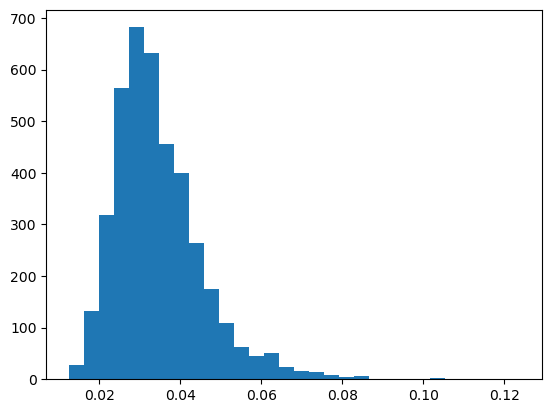

In [21]:
fig, ax = plt.subplots()
ax.hist(mse_all_drop, bins=30)
plt.show()

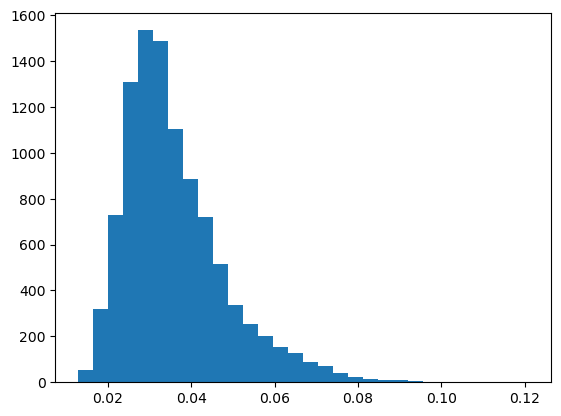

In [14]:
fig, ax = plt.subplots()
ax.hist(mse_all, bins=30)
plt.show()

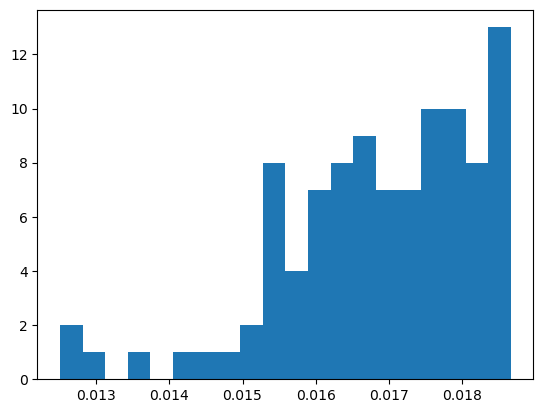

In [22]:
fig, ax = plt.subplots()
ax.hist(np.take(mse_all_drop, i_top), bins=20)
plt.show()

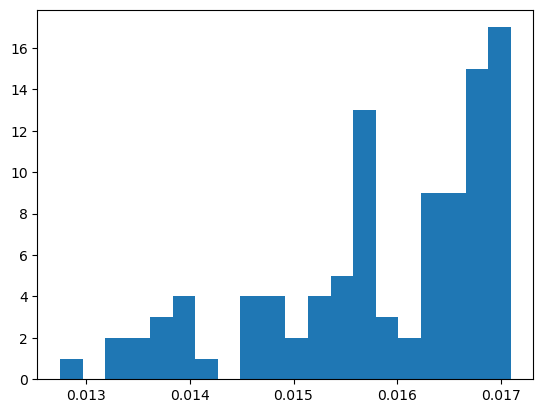

In [13]:
fig, ax = plt.subplots()
ax.hist(np.take(mse_all, i_top), bins=20)
plt.show()

In [15]:
####################### 5000

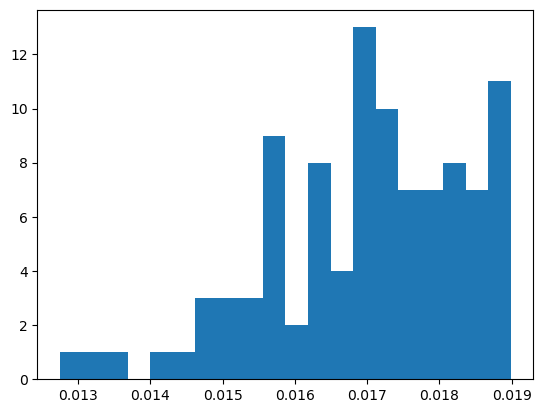

In [20]:
fig, ax = plt.subplots()
ax.hist(np.take(mse_all, i_top), bins=20)
plt.show()

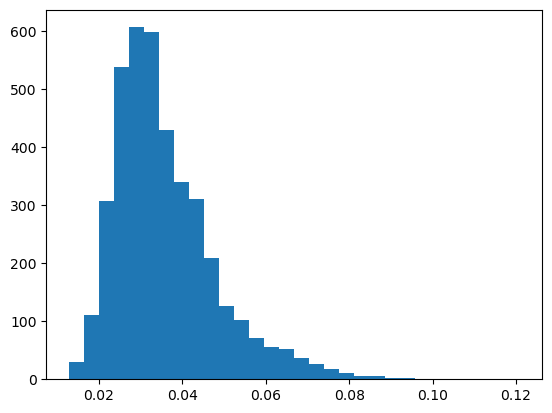

In [16]:
fig, ax = plt.subplots()
ax.hist(mse_all, bins=30)
plt.show()

In [24]:
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params.csv')
df_param[df_param.iparam == i_best]

,awCap_factor,wiltingp_factor,alpha_claycoef,alpha_sandcoef,alpha_siltcoef,betaHBV_claycoef,betaHBV_sandcoef,betaHBV_siltcoef,iparam
3638,1.278421,3.117335,5.789309,9.346146,3.214103,0.687924,0.024272,2.523833,3638


In [20]:
df_param = pd.read_csv(f'{project_path}/WBM/precalibration/centralUS/params.csv')
df_param[df_param.iparam == i_best]

,awCap_factor,wiltingp_factor,alpha_claycoef,alpha_sandcoef,alpha_siltcoef,betaHBV_claycoef,betaHBV_sandcoef,betaHBV_siltcoef,iparam
3638,1.278421,3.117335,5.789309,9.346146,3.214103,0.687924,0.024272,2.523833,3638


<Axes: ylabel='Frequency'>

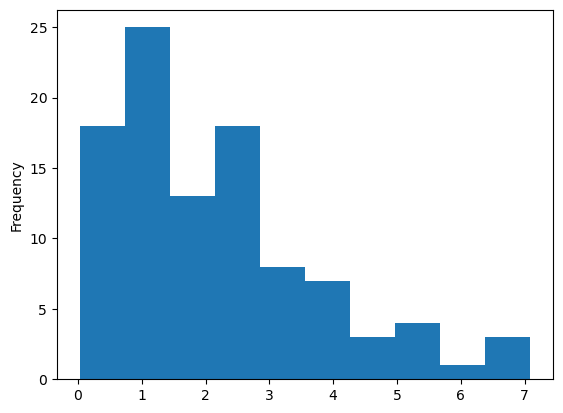

In [32]:
df_param[df_param.iparam.isin(i_top)]['betaHBV_siltcoef'].plot(kind='hist')

<Axes: ylabel='Frequency'>

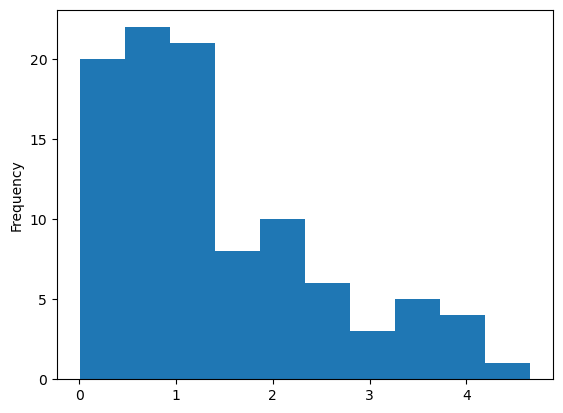

In [17]:
df_param[df_param.iparam.isin(i_top)]['betaHBV_siltcoef'].plot(kind='hist')

In [23]:
# Read obs and best
smap_obs = np.load(f'{project_path}/WBM/precalibration/centralUS/smap_obs.npy')
best_sim = np.load(f'{store_path}/{str(i_best)}_alphaC.npy')

In [31]:
tmp_sim_alpha = np.load(f'{store_path}/{str(i_best)}_alphaC.npy')
tmp_sim = np.load(f'{store_path}/{str(i_best)}.npy')

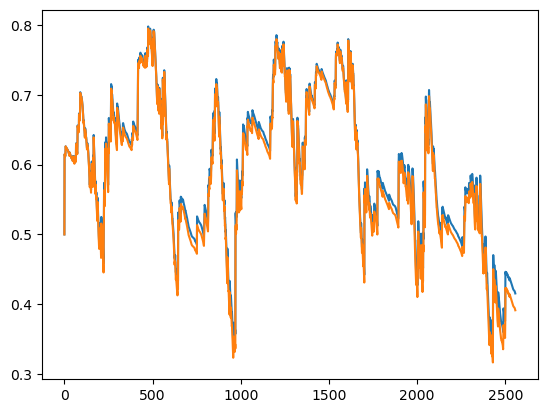

In [32]:
plt.plot(tmp_sim_alpha[106,66,:])
plt.plot(tmp_sim[106,66,:])

NameError: name 'best_sim' is not defined

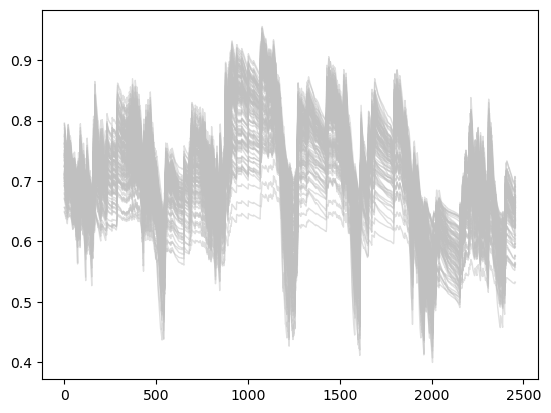

In [18]:
fig, ax = plt.subplots()

ix,iy=100,50

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}_alphaC.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

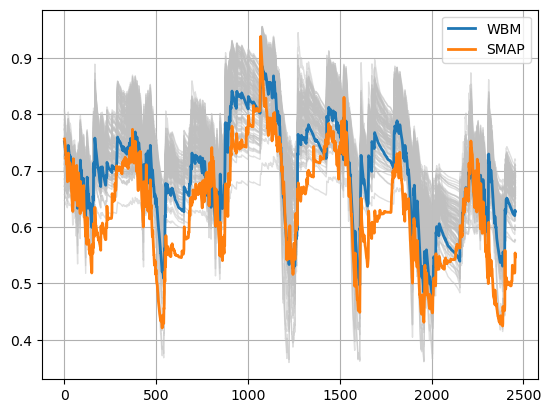

In [22]:
fig, ax = plt.subplots()

ix,iy=100,50

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

In [23]:
np.nanmax(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))))

/tmp/ipykernel_1101456/838063472.py:1: RuntimeWarning: Mean of empty slice
  np.nanmax(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))))


0.21198724

In [42]:
mse_spatial = np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2)
np.unravel_index(np.nanargmin(mse_spatial, axis=None), mse_spatial.shape)

/tmp/ipykernel_1101456/2300403976.py:1: RuntimeWarning: Mean of empty slice
  mse_spatial = np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2)


(87, 56)

In [71]:
ix,iy=106,66
np.nanmean((best_sim[ix,iy,100:] - smap_obs[ix,iy,100:])**2)

0.16763018

/tmp/ipykernel_1101456/1179283558.py:3: RuntimeWarning: Mean of empty slice
  img = ax.imshow(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))),


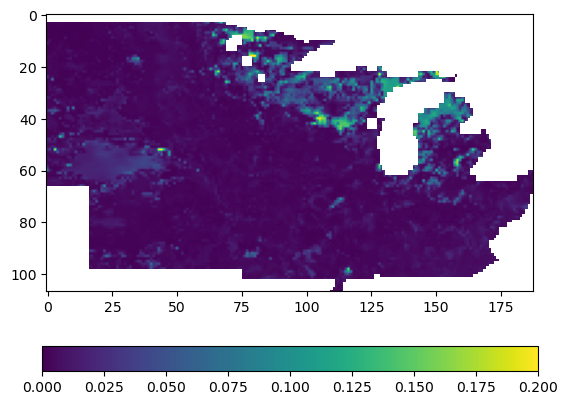

In [56]:
fig, ax = plt.subplots()

img = ax.imshow(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))),
               vmin=0., vmax=0.2)

fig.colorbar(img, ax=ax, orientation='horizontal', fraction=.1)

plt.show()

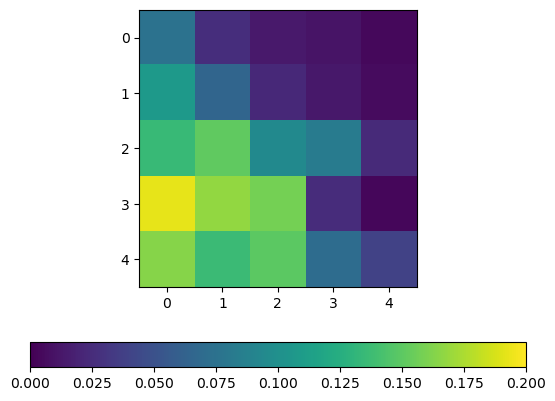

In [68]:
fig, ax = plt.subplots()

img = ax.imshow(np.flipud(np.transpose(np.nanmean((best_sim[105:110,65:70,100:] - smap_obs[105:110,65:70,100:])**2, axis=2))),
               vmin=0., vmax=0.2)

fig.colorbar(img, ax=ax, orientation='horizontal', fraction=.1)

plt.show()

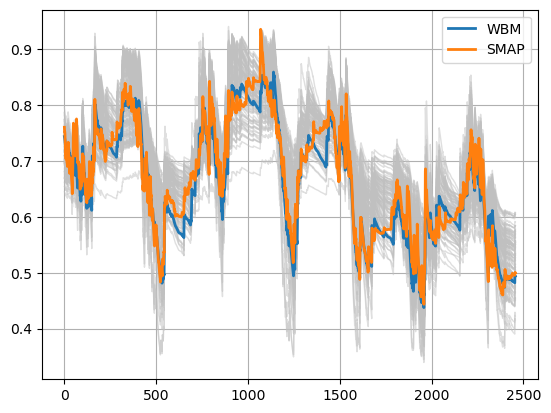

In [43]:
fig, ax = plt.subplots()

ix,iy=87,56

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

In [46]:
npz = np.load(f'{project_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz')

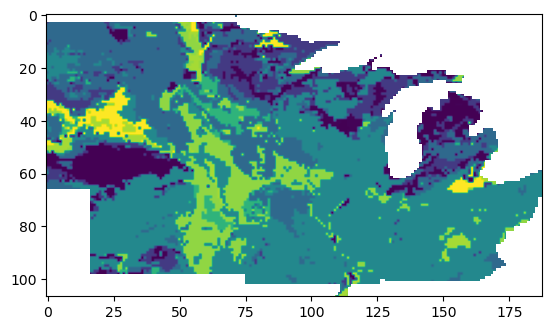

In [54]:
plt.imshow(np.flipud(np.transpose(npz['wiltingp'])))

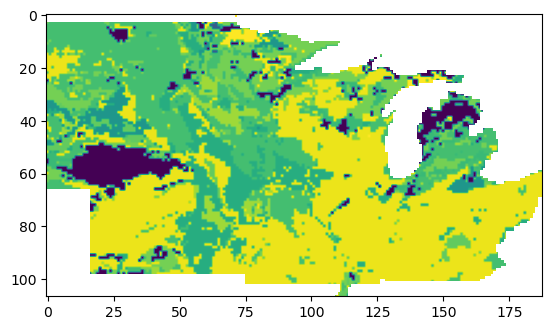

In [53]:
plt.imshow(np.flipud(np.transpose(npz['awCap'])))

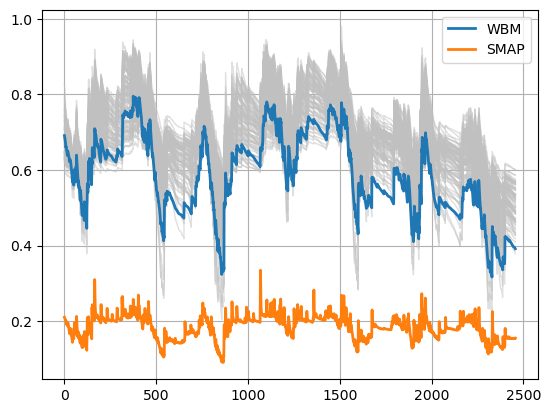

In [72]:
fig, ax = plt.subplots()

ix,iy=106,66

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

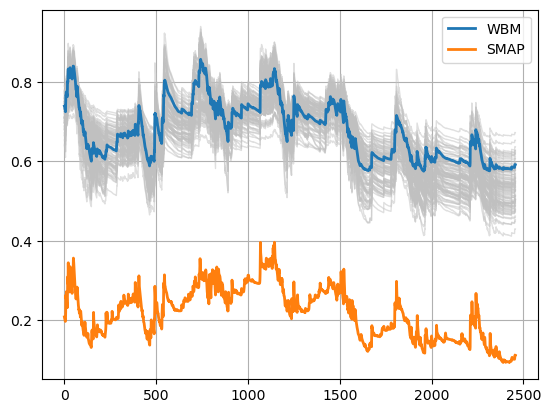

In [38]:
fig, ax = plt.subplots()

ix,iy=44,54

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()